In [1]:
from pathlib import Path

from pyaqua3ddev.image.image_processors.raw_processor import RawProcessor
from pyfishsensedev.image.pdf import Pdf
from pyfishsensedev.plane_detector.slate_detector import SlateDetector
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from pyfishsensedev.calibration.lens_calibration import LensCalibration
import torch
from pyfishsensedev.library.homography import viz2d
from pyfishsensedev.library.homography.utils import numpy_image_to_torch
from pyfishsensedev.library.homography.image_matcher import ImageMatcher
import cv2
import rawpy
from skimage.exposure import adjust_gamma, equalize_adapthist
from skimage.util import img_as_float, img_as_ubyte
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [3]:
input_file = Path("./data/PC100114.ORF")
pdf_file = Path("./data/SMILE vslate 2.pdf")
lens_calibration_file = Path("./data/fsl-05d-lens-raw.pkg")

input_file.exists(), pdf_file.exists(), lens_calibration_file.exists()

(True, True, True)

In [4]:
def imshow(image: np.ndarray, color="bgr"):
    image = img_as_ubyte(image)

    if image.ndim == 3:
        if color == "bgr":
            image = image[:, :, ::-1]

    plt.imshow(image)

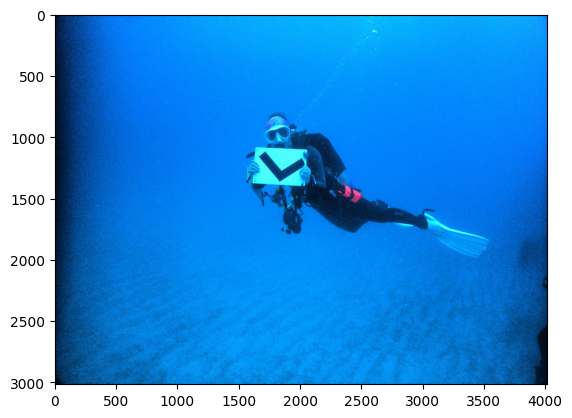

In [5]:
raw_processor = RawProcessor()
img = raw_processor.process(input_file)

imshow(img)

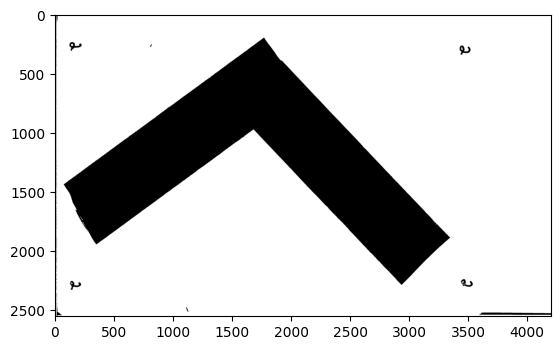

In [6]:
pdf = Pdf(pdf_file)
pdf.rotate(180)

imshow(pdf.image)

In [7]:
lens_calibration = LensCalibration()
lens_calibration.load(lens_calibration_file)

lens_calibration.camera_matrix

array([[2.83327797e+03, 0.00000000e+00, 2.00975722e+03],
       [0.00000000e+00, 2.85877370e+03, 1.40798662e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

/home/chris/Repos/school/e4e/fishsense/pyFishSenseDev/pyfishsensedev/library/homography/models/lightglue.py:29: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


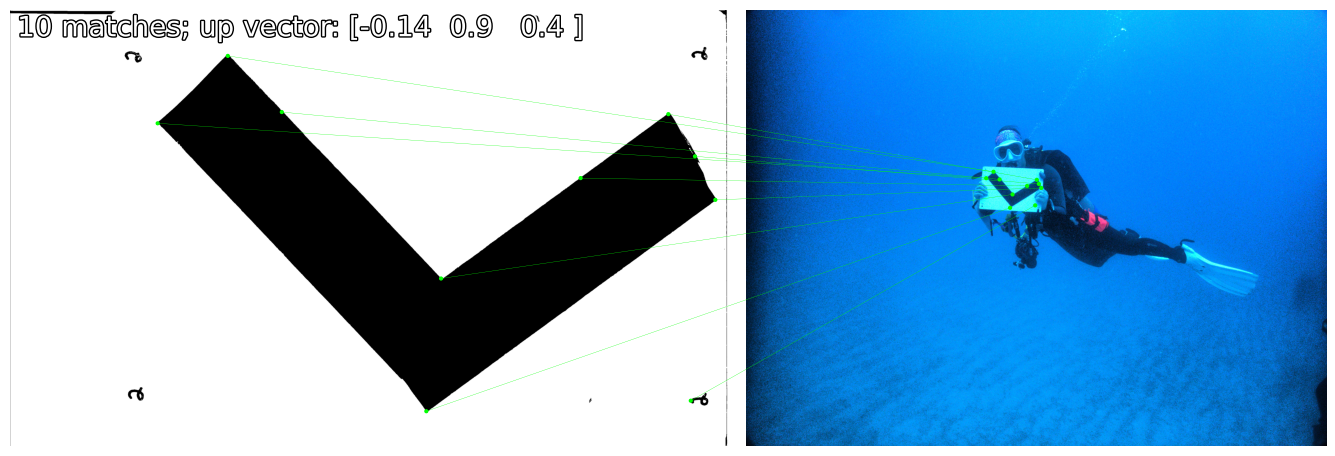

In [8]:
slate_detector = SlateDetector(img_as_ubyte(img), pdf, lens_calibration, device, try_multiple_slate_rotations=True)
template_matches, image_matches = slate_detector._get_template_matches()

rotation, _ = slate_detector._get_body_to_camera_space_transform()

viz2d.plot_images([slate_detector.pdf.image, img[:, :, ::-1]])
viz2d.plot_matches(template_matches, image_matches, color="lime", lw=0.2)
viz2d.add_text(
    0,
    f"{len(template_matches)} matches; up vector: {np.round(rotation @ np.array([0, 1, 0]) * 100.0) / 100.0}",
    fs=20,
)
plt.show()